In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics import ConfusionMatrix
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)

import warnings
warnings.filterwarnings('ignore')

import pickle

from pytorchclassifier import ClassificationModel, accuracy_fn, encoding

d:\ML_ENV\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
data=pd.read_csv("datasets/diabetes_data_upload.csv")
data_copy=data.copy()
data_copy.head(2)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive


In [3]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [4]:
data_copy['class'].value_counts()

class
Positive    320
Negative    200
Name: count, dtype: int64

In [5]:
cat_columns=data_copy.select_dtypes(include=['object']).columns
num_columns=data_copy.select_dtypes(exclude=['object']).columns
cat_columns,num_columns=list(cat_columns),list(num_columns)
columns=list(data_copy.columns)
encoding(data_copy,cat_columns)
data_copy.head(2)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1


In [6]:
X_train,X_test=train_test_split(data_copy,test_size=0.3,random_state=42,shuffle=True,stratify=data_copy['class'])
X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=42, shuffle=True, stratify=X_test['class'])

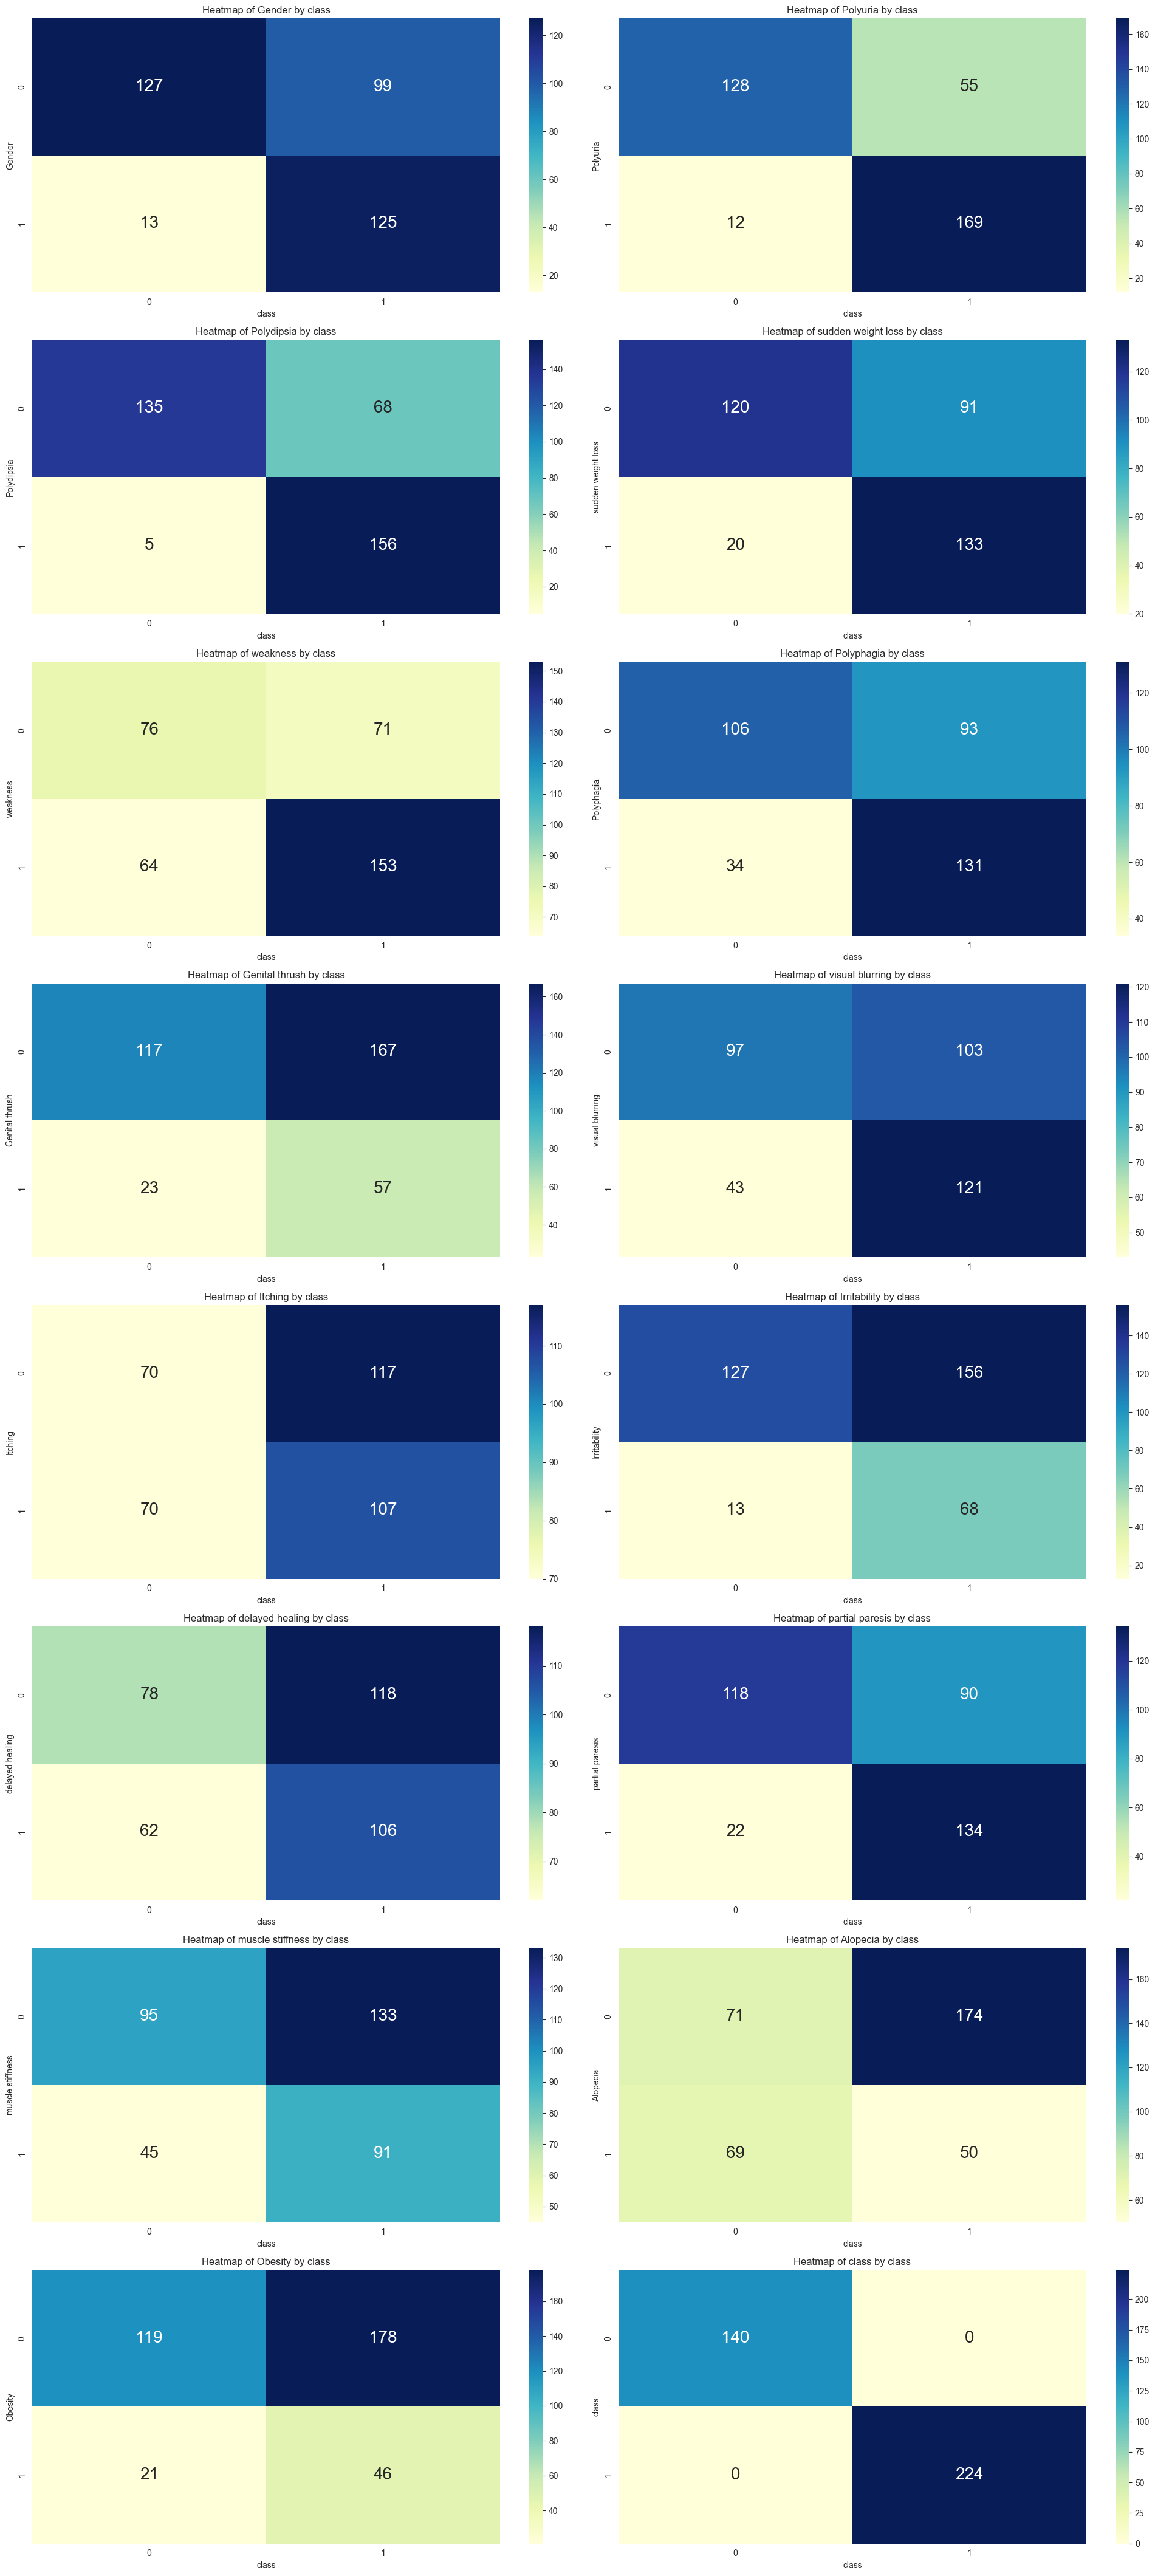

In [7]:
# Set the style and palette for seaborn
sns.set_style("whitegrid")
sns.set_palette("pastel")

# Create subplots with 2 columns
fig, axes = plt.subplots(nrows=(len(cat_columns) + 1) // 2, ncols=2, figsize=(20, (len(cat_columns) + 1) * 2.5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(cat_columns):
    ax = axes[i]
    # Create a crosstab for the feature and class
    crosstab = pd.crosstab(X_train[feature], X_train['class'])
    sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu", ax=ax, annot_kws={"size": 20})
    ax.set_title(f'Heatmap of {feature} by class')
    ax.set_ylabel(feature)
    ax.set_xlabel('class')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()

# Save the figure
#plt.savefig("plots/heatmaps.png", bbox_inches='tight')

# Show the figure
plt.show()


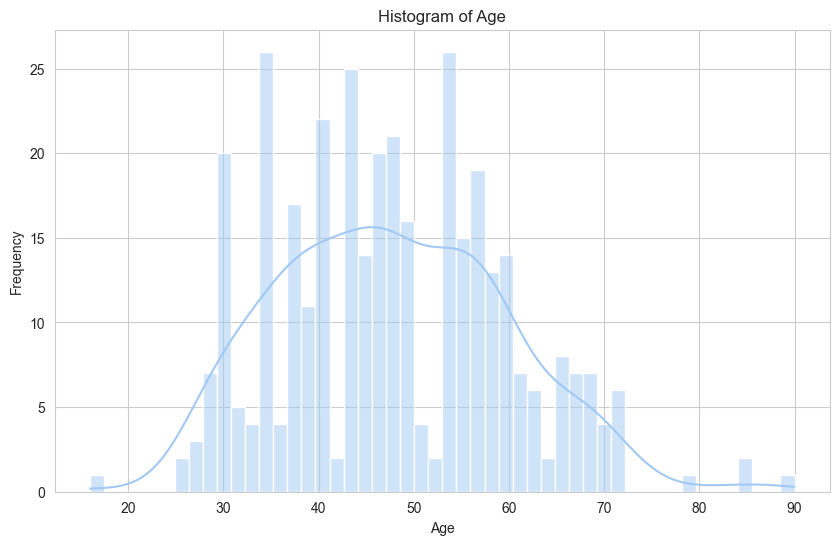

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(data=X_train, x='Age', bins=50, kde=True)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
#plt.savefig("plots/age_histogram.png", bbox_inches='tight')
plt.show()

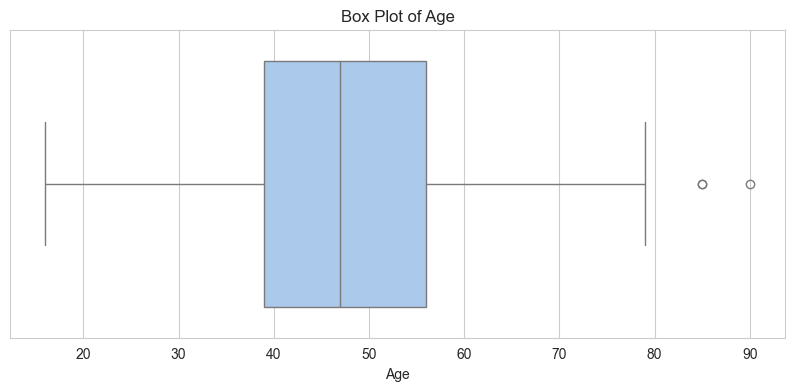

In [9]:
plt.figure(figsize=(10, 4))
sns.boxplot(data=X_train, x='Age')
plt.title('Box Plot of Age')
plt.xlabel('Age')
#plt.savefig("plots/age_boxplot.png", bbox_inches='tight')
plt.show()

In [10]:
from sklearn.preprocessing import RobustScaler
scaler=RobustScaler()
for column in num_columns:
    X_train[column]=scaler.fit_transform(X_train[[column]])
    X_test[column]=scaler.transform(X_test[[column]])
    X_val[column]=scaler.transform(X_val[[column]])

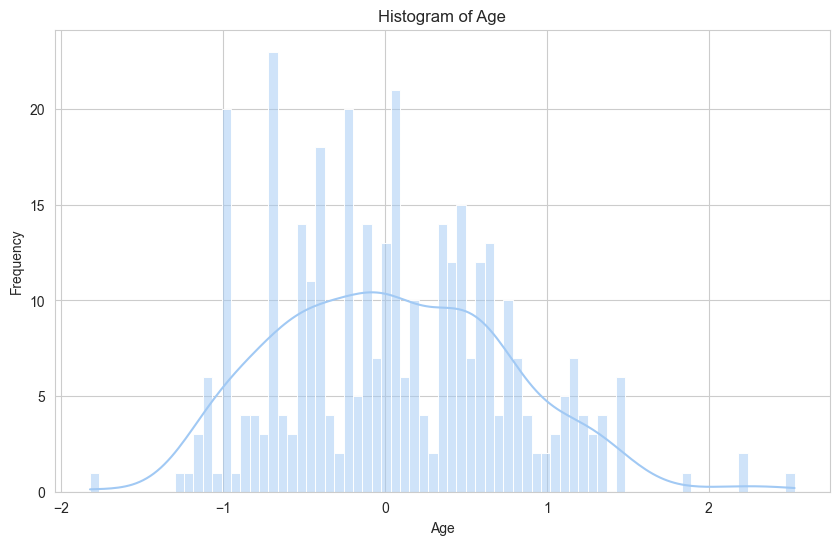

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=X_train, x='Age', bins=75, kde=True)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
#plt.savefig("plots/age_histogram.png", bbox_inches='tight')
plt.show()

In [12]:
X_train, y_train = X_train.iloc[:, :-1].values, X_train.iloc[:, -1].values
X_val, y_val = X_val.iloc[:, :-1].values, X_val.iloc[:, -1].values
X_test, y_test = X_test.iloc[:, :-1].values, X_test.iloc[:, -1].values

In [13]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor([class_weights[1]], dtype=torch.float32)

X_train,y_train=torch.from_numpy(X_train).to(torch.float32),torch.from_numpy(y_train).to(torch.float32)

X_test,X_val=torch.from_numpy(X_test).to(torch.float32),torch.from_numpy(X_val).to(torch.float32)

y_test,y_val=torch.from_numpy(y_test).to(torch.float32),torch.from_numpy(y_val).to(torch.float32)

In [14]:
model=ClassificationModel(len(X_train[0]),64)
metric = ConfusionMatrix(task="binary", num_classes=2)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer=torch.optim.Adam(params=model.parameters(),lr=0.008)

In [15]:
torch.manual_seed(42)
epochs=50
for epoch in range(epochs):
    model.train()
    y_logits=model(X_train).squeeze()
    y_train_pred=torch.round(torch.sigmoid(y_logits))

    loss=loss_fn(y_logits,y_train)
    accuracy=accuracy_fn(y_train,y_train_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Testing
    model.eval()
    with torch.inference_mode():
        y_val_logits=model(X_val).squeeze()
        y_val_pred=torch.round(torch.sigmoid(y_val_logits))
        Val_loss=loss_fn(y_val_logits,y_val)
        Val_accuracy=accuracy_fn(y_val_pred,y_val)
    if epoch%5==0:
        print(f"Epoch->{epoch}, Train_loss-->{loss:.3f}, Train_accuracy-->{accuracy:.3f}, Test_loss-->{Val_loss:.3f} Test_accuracy-->{Val_accuracy:.3f}")

Epoch->0, Train_loss-->0.611, Train_accuracy-->61.538, Test_loss-->0.590 Test_accuracy-->61.538
Epoch->5, Train_loss-->0.275, Train_accuracy-->90.385, Test_loss-->0.242 Test_accuracy-->89.744
Epoch->10, Train_loss-->0.137, Train_accuracy-->95.055, Test_loss-->0.192 Test_accuracy-->93.590
Epoch->15, Train_loss-->0.068, Train_accuracy-->97.802, Test_loss-->0.139 Test_accuracy-->92.308
Epoch->20, Train_loss-->0.032, Train_accuracy-->98.901, Test_loss-->0.111 Test_accuracy-->96.154
Epoch->25, Train_loss-->0.020, Train_accuracy-->99.725, Test_loss-->0.165 Test_accuracy-->92.308
Epoch->30, Train_loss-->0.011, Train_accuracy-->99.725, Test_loss-->0.165 Test_accuracy-->94.872
Epoch->35, Train_loss-->0.015, Train_accuracy-->99.176, Test_loss-->0.142 Test_accuracy-->94.872
Epoch->40, Train_loss-->0.002, Train_accuracy-->100.000, Test_loss-->0.164 Test_accuracy-->96.154
Epoch->45, Train_loss-->0.010, Train_accuracy-->98.901, Test_loss-->0.187 Test_accuracy-->96.154


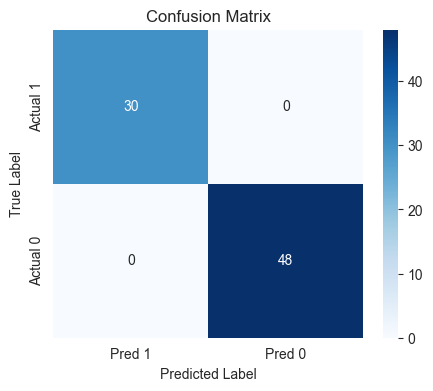

ROC AUC Score: 1.0000


In [16]:
model.eval()
with torch.inference_mode():
    y_test_logits=model(X_test).squeeze()
    y_test_pred=torch.round(torch.sigmoid(y_test_logits))
cm1 = metric(y_test,y_test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=["Pred 1", "Pred 0"], yticklabels=["Actual 1", "Actual 0"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_test.detach().numpy(), y_test_pred.detach().numpy())

print(f"ROC AUC Score: {auc_score:.4f}")

In [17]:
try:
    cat_columns.remove('class')
    columns.remove('class')
except:
    pass

columns_dict={
    'cat_columns':cat_columns,
    'num_columns':num_columns,
    'columns':columns
}

In [18]:
pickle.dump(scaler,open('models/pytorch_scaler.pkl','wb'))
pickle.dump(columns_dict,open('models/columns_dict.pkl','wb'))
torch.save(model,'models/pytorch_model.pt')